In [5]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from scipy import io as sio
from tensorflow.python.framework import ops
from dfs2 import DeepFeatureSelectionNew
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import normalize

# ourdataB = sio.loadmat("/Volumes/TONY/Regeneron/Data/OriginalData/newDataB_2labels.mat")
ourdataB = sio.loadmat("/Users/xupeng.tong/Documents/Data/OriginalData/newDataB_2labels.mat")

inputX = ourdataB['X']
inputX = normalize(inputX, axis=0)
inputY = ourdataB['Y'][0,:]
columnNames = ourdataB['columnNames']

X_train, X_test, y_train, y_test = train_test_split(inputX, inputY, test_size=0.2, random_state=42)

In [6]:

X_train500, X_test500 = X_train[:, indexes.tolist()[0][:500]], X_test[:, indexes.tolist()[0][:500]]
X_train100, X_test100 = X_train[:, indexes.tolist()[0][:100]], X_test[:, indexes.tolist()[0][:100]]
X_train10, X_test10 = X_train[:, indexes.tolist()[0][:10]], X_test[:, indexes.tolist()[0][:10]]
X_train50, X_test50 = X_train[:, indexes.tolist()[0][:50]], X_test[:, indexes.tolist()[0][:50]]

# Run the Deep Feature Selection
## Changing lambda1 slightly

In [1]:
ops.reset_default_graph()

weights = []
for lambda1 in xrange(0, 10, 1):
    lambda1 /= 10000.
    dfsMLP = DeepFeatureSelectionNew(X_train, X_test, y_train, y_test, n_input=1, hidden_dims=[50], learning_rate=0.01, \
                                     lambda1=lambda1, lambda2=1, alpha1=0.0000001, alpha2=0, activation='tanh', \
                                     weight_init='uniform',epochs=50, optimizer='Adam', print_step=1)
    dfsMLP.train(batch_size=2000)
    print("Train finised for lambda1:" + str(lambda1))
    weights.append(dfsMLP.selected_ws[0])

# Create feature selection function

In [ ]:
import numpy as np

indexes_xgboost = sio.loadmat("xgboost_result")['importance_rank']

weights = np.load('weights-7000-0-0001.npy')

indexes_dfs = np.argsort(abs(weights[0]))[::-1]

def topXGBoostfeatures(n):
    return X_train[:, indexes_xgboost.tolist()[0][:n]], X_test[:, indexes_xgboost.tolist()[0][:n]]

def topDFSfeatures(n):
    return X_train[:, indexes_dfs.tolist()[:n]], X_test[:, indexes_dfs.tolist()[:n]]

In [ ]:
len(abs(dfsMLP.selected_ws[0])[abs(dfsMLP.selected_ws[0])>0.001])

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

plotly.tools.set_credentials_file(username='tonyabracadabra', api_key='6gs9i5iec7')


data = [
    go.Heatmap(
        z=weights
    )
]

py.iplot(data, filename='basic-heatmap')

In [ ]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

batch_size = 2000
nb_classes = 2
nb_epoch = 500

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Dense(300, input_shape=(500,)))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train500, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test500, Y_test))
score = model.evaluate(X_test500, Y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
y_train_tf = y_train.reshape(y_train.shape[0],1)

In [ ]:
X_train.shape

In [ ]:
import tflearn
import tensorflow as tf

# Classification
# tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5)

with tf.Graph().as_default():
    inputlayer = tflearn.input_data(shape=[None, 7203])
    dense = tflearn.fully_connected(inputlayer, 300, activation='tanh')
    sofmax = tflearn.fully_connected(dense, 2, activation='softmax')
    net = tflearn.regression(sofmax, optimizer='sgd', loss='categorical_crossentropy')

    model = tflearn.DNN(net)
    model.fit(X_train500, Y_train, n_epoch=10, show_metric=True, validation_set=(X_test500, Y_test))

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

temp = abs(dfsMLP.selected_ws[0])

plt.plot(temp)

In [ ]:
temp = dfsMLP.selected_ws

temp1, temp2 = temp[0], temp[1]

In [ ]:
np.where(abs(temp1)<0.01)

In [ ]:
np.where(abs(temp2)<0.01)

In [ ]:
temp = dfsMLP.selected_ws

temp3, temp4 = temp[0], temp[1]

print(np.where(abs(temp3)<0.01))
print(np.where(abs(temp4)<0.01))

In [ ]:
temp = dfsMLP.selected_ws

temp5, temp6 = temp[0], temp[1]

print(np.where(abs(temp5)<0.01))
print(np.where(abs(temp6)<0.01))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb

# rf = RandomForestClassifier(criterion="entropy", n_estimators = 300, max_depth = 100)
# rf.fit(X_train, y_train)

# y_pred = rf.predict(X_test)

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=400, learning_rate=0.05).fit(X_train, y_train)
y_pred = gbm.predict(X_test)

print(accuracy_score(y_test, y_pred))

# gbm10 = xgb.XGBClassifier(max_depth=3, n_estimators=400, learning_rate=0.05).fit(X_train10, y_train)
# y_pred10 = gbm.predict(X_test10)

# print(accuracy_score(y_test, y_pred))

In [ ]:
indexes = np.argsort(gbm.feature_importances_)[::-1]

# top100Features = np.array([columnNames[0][i] for i in indexes[0:200]])
# top100Features = np.array([columnNames[i] for i in indexes[0:100]])
# top100Features = top100Features.reshape(100,)

In [165]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

plotly.tools.set_credentials_file(username='tonyabracadabra', api_key='6gs9i5iec7')

data = [
    go.Heatmap(
        z=np.abs(weights[1:])
    )
]

py.iplot(data, filename='basic-heatmap')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tonyabracadabra/0 or inside your plot.ly account where it is named 'basic-heatmap'


In [141]:
keke_train = X_train[:,np.argwhere(abs(weights[0])>0.15).reshape(294,)]
keke_test = X_test[:,np.argwhere(abs(weights[0])>0.15).reshape(294,)]

In [119]:
dfs_train500

(500, 7203)

In [116]:
X_train.shape

(8547, 7203)

In [93]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

acc_scores_xgboost_svm = []
# acc_scores_xgboost = []
for n in xrange(1,1000):
    if n % 50 == 0:
        print(n)
    xtrain, xtest = topXGBoostfeatures(n)
    svm.fit(xtrain, y_train)
    y_pred = svm.predict(xtest)
    acc_scores_xgboost_svm.append(accuracy_score(y_test, y_pred))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [57]:
# acc_scores_dfs = []
acc_scores_dfs_svm = []
for n in xrange(1,1000):
    if n % 50 == 0:
        print(n)
    xtrain, xtest = topDFSfeatures(n)
    svm.fit(xtrain, y_train)
    y_pred = svm.predict(xtest)
    acc_scores_dfs_svm.append(accuracy_score(y_test, y_pred))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [174]:
from sklearn.svm import LinearSVC

svm = LinearSVC()

# clf = LogisticRegression(penalty="l2")

# keke, keke_test = topDFSfeatures(100)
# # keke, keke_test = topXGBoostfeatures(30)
# svm.fit(keke, y_train)
# y_pred = svm.predict(keke_test)
# print(accuracy_score(y_test, y_pred))

xtrain, xtest = X_train[:,featureMask], X_test[:, featureMask]
svm.fit(xtrain, y_train)
y_pred = svm.predict(xtest)
print(accuracy_score(y_test, y_pred))

0.948058025269


In [152]:
hoho, hoho_test = X_train[:, indexes.tolist()[0][3000:]], X_test[:, indexes.tolist()[0][3000:]]

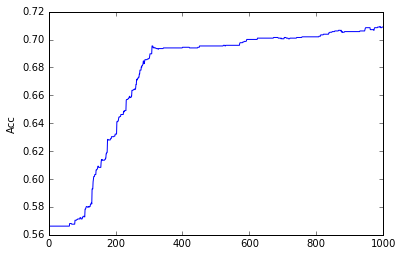

In [126]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(acc_scores_xgboost)
plt.ylabel('Acc')
plt.show()

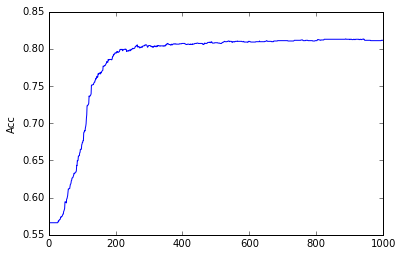

In [147]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(acc_scores_dfs)
plt.ylabel('Acc')
plt.show()

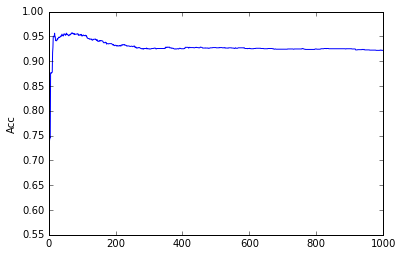

In [58]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(acc_scores_dfs_svm)
plt.ylabel('Acc')
plt.show()

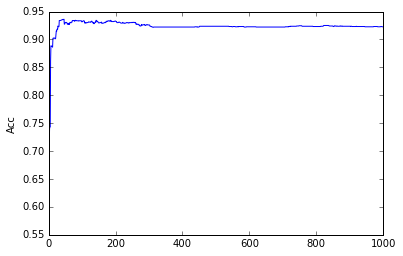

In [94]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(acc_scores_xgboost_svm)
plt.ylabel('Acc')
plt.show()

In [126]:
# columnNames[0][index_list_dfs][:50]

In [127]:
# columnNames[0][indexes.tolist()][:50]

In [172]:
from sklearn.linear_model import RandomizedLogisticRegression

randomized_lasso = RandomizedLogisticRegression(selection_threshold=0.2)
randomized_lasso.fit(X_train, y_train)

featureMask = randomized_lasso.get_support()

/Users/xupeng.tong/anaconda/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning:

This function is deprecated. Please call randint(0, 1 + 1) instead

/Users/xupeng.tong/anaconda/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning:

This function is deprecated. Please call randint(0, 1 + 1) instead

/Users/xupeng.tong/anaconda/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning:

This function is deprecated. Please call randint(0, 1 + 1) instead

/Users/xupeng.tong/anaconda/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning:

This function is deprecated. Please call randint(0, 1 + 1) instead

/Users/xupeng.tong/anaconda/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning:

This function is deprecated. Please call randint(0, 1 + 1) instead

/Users/xupeng.tong/anaconda/lib/python2.7/site-packages/sklearn/l

In [173]:
xx = X_train[:,featureMask]

xx.shape

(8547, 38)

In [171]:
columnNames[:100][featureMask]

/Users/xupeng.tong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning:

boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 7203



IndexError: index 1 is out of bounds for axis 0 with size 1

In [179]:
acc_scores_dfs_svm[:30]

[0.5662143191389799,
 0.71268132896583991,
 0.73467477772578382,
 0.74075807206364064,
 0.74684136640149745,
 0.74543752924660744,
 0.87412260177819368,
 0.8769302760879738,
 0.87599438465138046,
 0.8769302760879738,
 0.8769302760879738,
 0.87833411324286381,
 0.91717360786148805,
 0.92793635938231167,
 0.95039775386055214,
 0.94992980814225547,
 0.9494618624239588,
 0.9494618624239588,
 0.95648104819840896,
 0.94899391670566213,
 0.94899391670566213,
 0.94150678521291531,
 0.94150678521291531,
 0.94197473093121198,
 0.94103883949461864,
 0.94244267664950865,
 0.94525035095928878,
 0.94384651380439866,
 0.94525035095928878,
 0.94712213383247545]